In [1]:
import json
import gcsfs
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from dask.distributed import Client, LocalCluster
import dask
import zarr
from dask.diagnostics import ProgressBar
import cartopy.crs as ccrs

from utils import smooth_inputs_dataset
from cm26_utils import load_and_combine_cm26

# set up gcs filesystem
# 👇 replace with your key 
with open( '/home/jovyan/KEYS/pangeo-forge-ocean-transport-4967-347e2048c5a1.json') as token_file:
    token = json.load(token_file)
fs = gcsfs.GCSFileSystem(token=token)
%config InlineBackend.figure_format='retina'

## Define the terms we will be looking at

Full output : $ \left \langle \overline{Q\left(T, U\right)} \right\rangle$

Large Scale Contribution : $\overline{Q\left(\left \langle T \right \rangle, \left \langle U \right \rangle \right)}$

Small Scale Contribution : $ \left \langle \overline{Q\left(T, U\right)} \right\rangle - \overline{Q\left(\left \langle T \right \rangle, \left \langle U \right \rangle \right)}$

$ \left \langle \overline{Q\left(T, U\right)} \right\rangle - \left \langle \overline{Q\left(T, \left \langle U \right \rangle \right)} \right\rangle$

$ \left \langle \overline{Q\left(T, U\right)} \right\rangle - \left \langle \overline{Q\left(\left \langle T \right \rangle, U\right)} \right\rangle$



In [10]:
def scale_separation(ds, filter_scale):
    ds_filtered = smooth_inputs_dataset(
        ds,
        ['yt_ocean', 'xt_ocean'],
        filter_scale
    )
    diff_filtered = ds_filtered.sel(smoothing='smooth_full')-ds_filtered.sel(smoothing=['smooth_all', 'smooth_tracer', 'smooth_vel'])
    diff_unfiltered = ds_filtered.sel(smoothing='smooth_full')-ds.sel(smoothing=['smooth_all', 'smooth_tracer', 'smooth_vel'])
    
    # assigne scale datasets
    ds_full=ds_filtered.sel(smoothing='smooth_full')
    
    ds_large_scale = ds_filtered.sel(smoothing='smooth_all')
    
    ds_small_scale = xr.concat(
        [
            diff_unfiltered.sel(smoothing='smooth_all'), # the main result,
            diff_filtered.sel(smoothing=['smooth_tracer', 'smooth_vel']), # The mechanism 'hints'
        ],
        dim='smoothing'
    )
    
    return ds_full, ds_large_scale, ds_small_scale

In [2]:
def subsample(da, subsample):
    return da.isel(xt_ocean=slice(0, None, subsample), yt_ocean=slice(0, None, subsample))

# Ice Mask + Eroded Land

Text(0.5, 1.0, 'Final ocean mask')

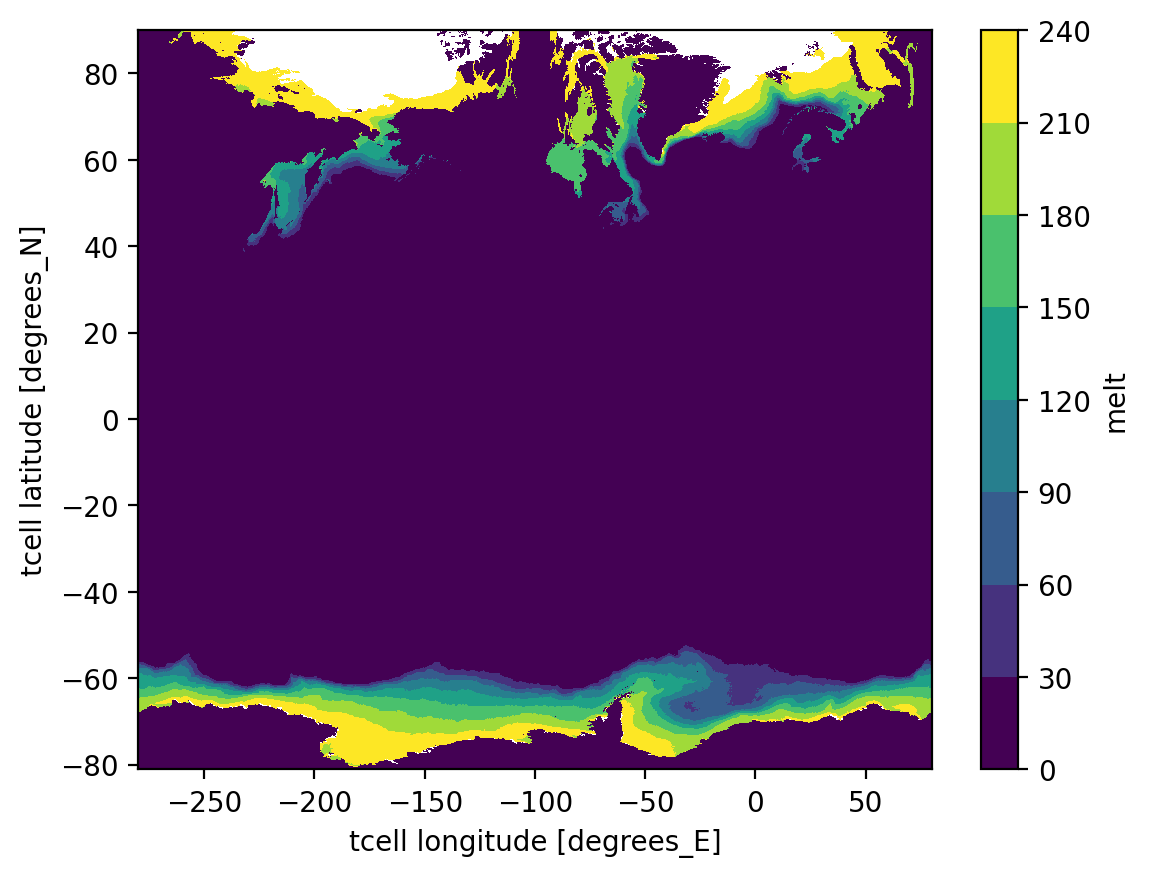

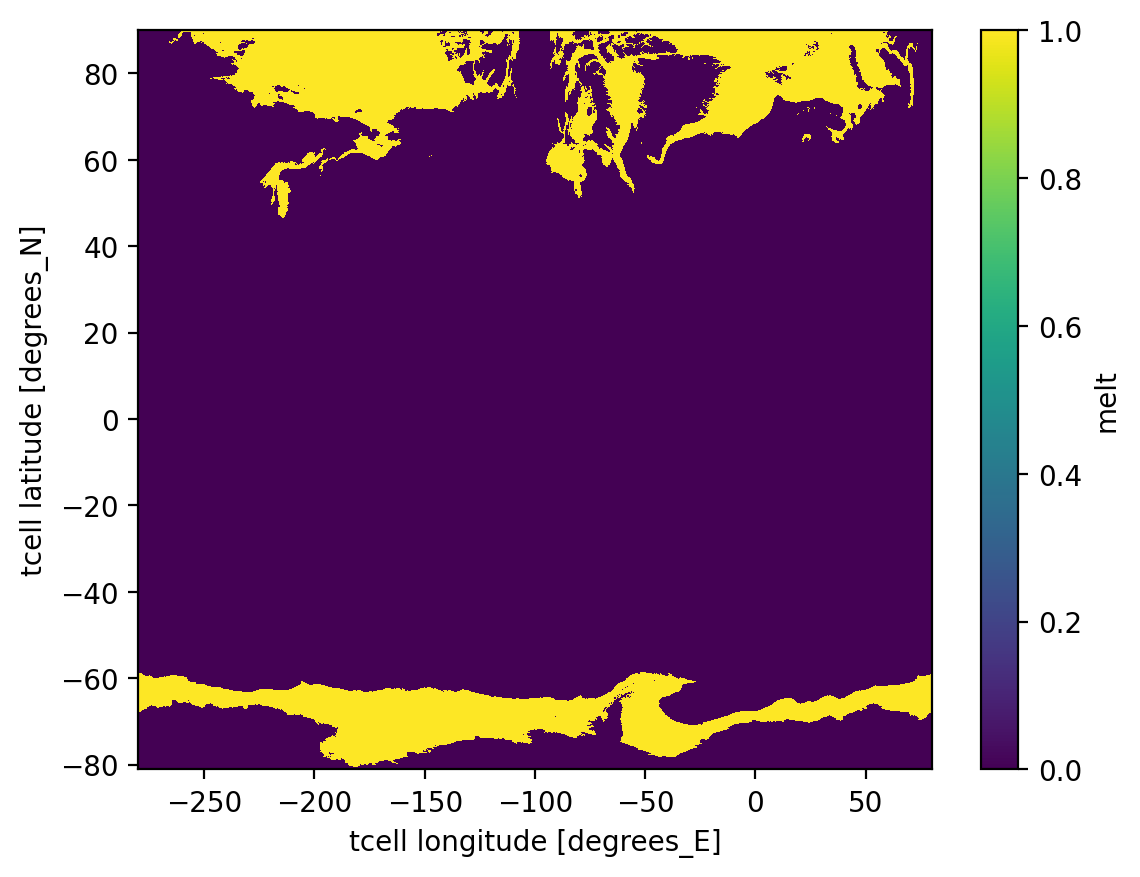

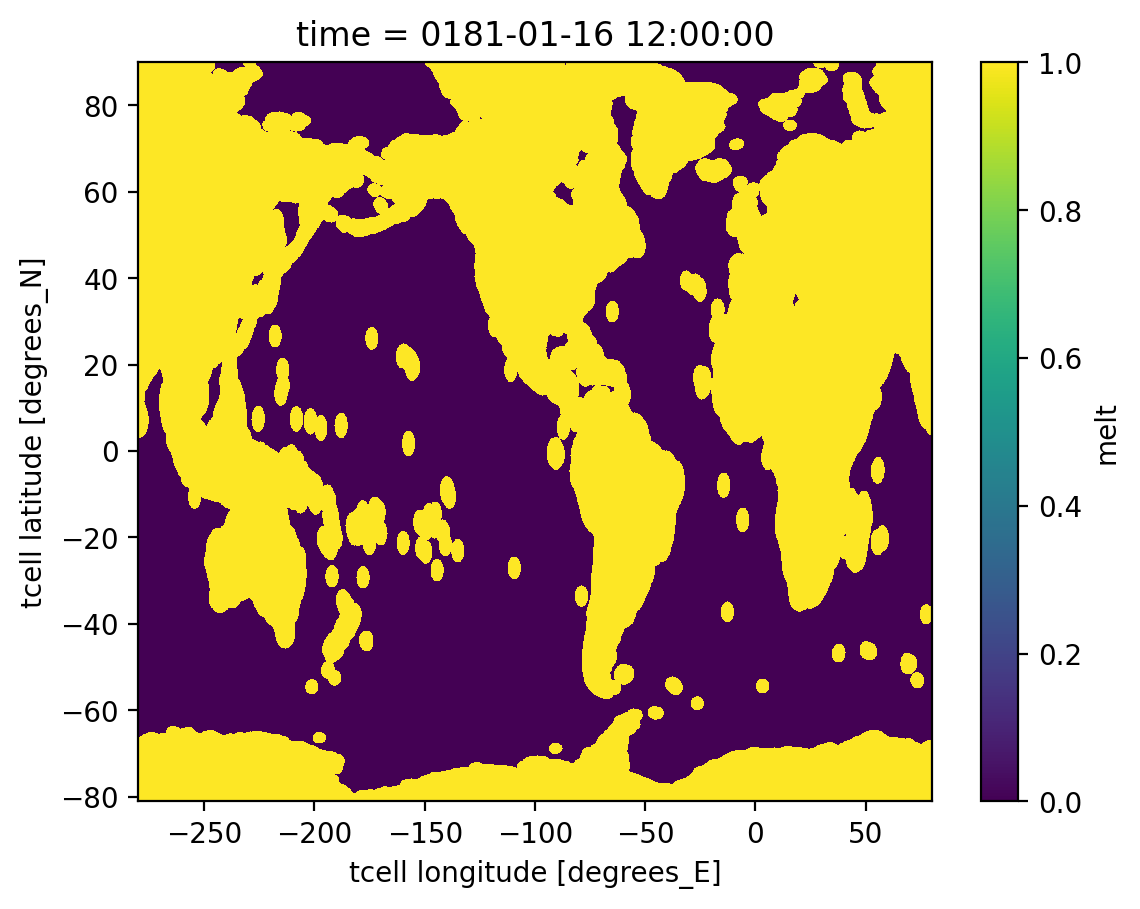

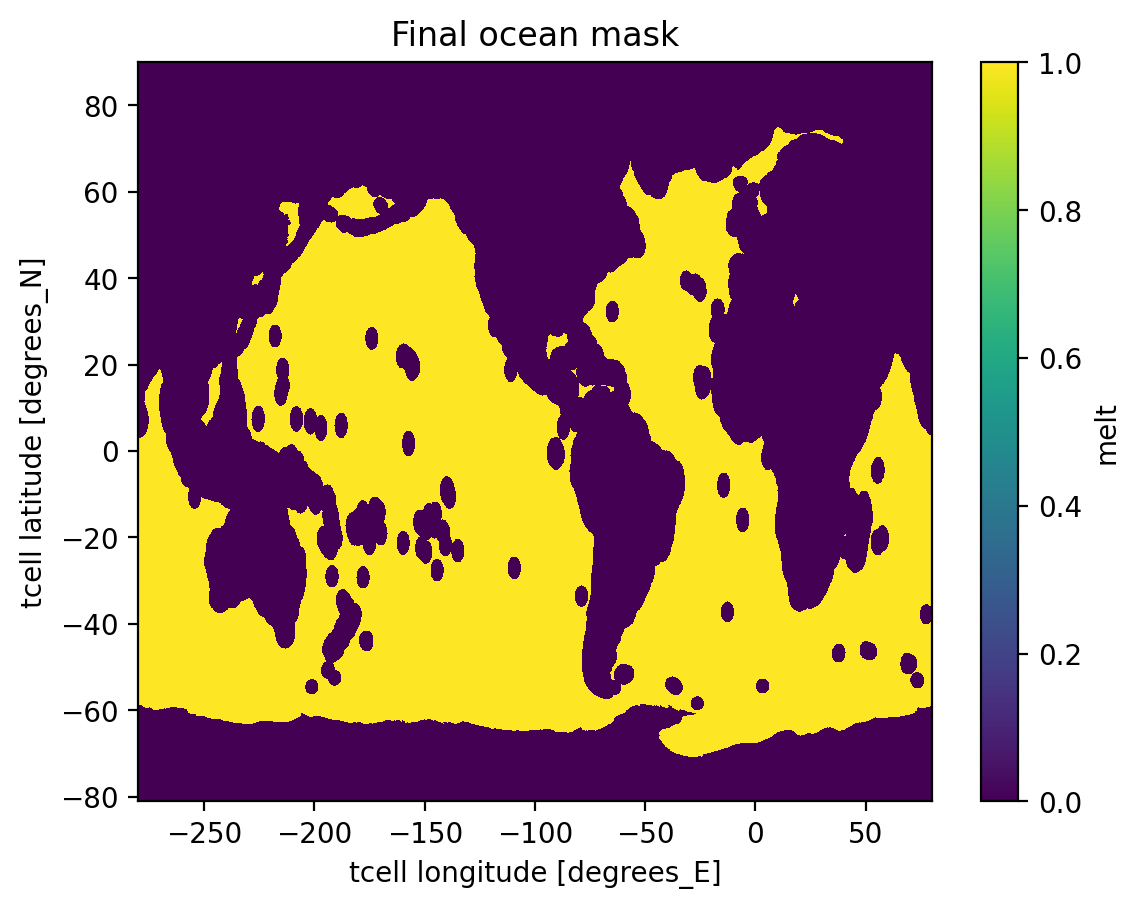

In [3]:
# quick and dirty look
from intake import open_catalog

cat = open_catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/GFDL_CM2.6.yaml")
ds_mask  = cat["GFDL_CM2_6_control_ocean_boundary_flux"].to_dask()

plt.figure()
(np.abs(ds_mask['melt'])>0).astype(int).sum('time').plot(levels=10)
# super restrictive
# ice_mask = (np.abs(ds['melt'])>0).any('time')
# mask areas that are on average more than 6 months ice covered
ice_mask = ((np.abs(ds_mask['melt'])>0).sum('time')>120)
plt.figure()
ice_mask.plot()

from skimage.morphology import erosion, disk 
# make a bigger land mask
land = np.isnan(ds_mask['melt'].isel(time=0)).load()
land_eroded = xr.ones_like(land) * np.nan
land_eroded.data = ~erosion(~land.data, footprint=disk(30))
plt.figure()
land_eroded.plot()

mask_combined = np.logical_and(~ice_mask, ~land_eroded)
plt.figure()
mask_combined.plot()
plt.title('Final ocean mask')

## Load processed results

In [4]:
ds_original = load_and_combine_cm26(fs, inline_array=True)
# ds_original

Load Data
Align in time
Interpolating ocean velocities
Regrid Atmospheric Data
Modify units
Mask nans
Calculate relative wind


In [5]:
smooth_path =  'ocean-transport-group/scale-aware-air-sea/preprocessed/CM26_smoothed_split_v2.zarr'
smooth_mapper = fs.get_mapper(smooth_path)
ds_smoothed = xr.open_dataset(smooth_mapper, engine='zarr', chunks={}, consolidated=True)
# extract the filter scale used (TODO: Check that it is the same for all variables?
filter_scale = ds_smoothed.slp_smoothed.attrs['filter_scale']
# ds_smoothed

In [6]:
# TODO: Remove old stores ones once new work (from all levels of processing)

In [7]:
fs.ls('ocean-transport-group/scale-aware-air-sea/results')

['ocean-transport-group/scale-aware-air-sea/results/cm26_flux_long_term_mean_v2.zarr',
 'ocean-transport-group/scale-aware-air-sea/results/cm26_flux_seasonal_mean_v2.zarr']

In [ ]:
def load_results(mapper, mask):
    ds_loaded = xr.open_dataset(
        mapper,
        engine='zarr',
        chunks={},
        consolidated=True,
    )
    ds_loaded = ds_loaded.where(mask)
    return ds_loaded

In [ ]:
mean_mapper = fs.get_mapper('ocean-transport-group/scale-aware-air-sea/results/cm26_flux_long_term_mean_v2.zarr')
season_mapper = fs.get_mapper('ocean-transport-group/scale-aware-air-sea/results/cm26_flux_seasonal_mean_v2.zarr')

In [8]:
# results_path = 'ocean-transport-group/scale-aware-air-sea/results/cm26_flux_long_term_mean_v2.zarr'
# ds_results = xr.open_dataset(
#     fs.get_mapper(results_path),
#     engine='zarr',
#     chunks={},
#     consolidated=True
# )
# ds_results
# ds_results = ds_results.where(mask_combined)
ds_results_mean = load_results(mean_mapper, mask_combined)
ds_results_season = load_results(season_mapper, mask_combined)

<xarray.Dataset>
Dimensions:    (algo: 5, smoothing: 4, yt_ocean: 2700, xt_ocean: 3600)
Coordinates:
  * algo       (algo) <U8 'ncar' 'ecmwf' 'coare3p0' 'coare3p6' 'andreas'
  * smoothing  (smoothing) <U13 'smooth_full' 'smooth_tracer' ... 'smooth_all'
  * xt_ocean   (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean   (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
Data variables:
    evap       (smoothing, algo, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 2700, 3600), meta=np.ndarray>
    qh         (smoothing, algo, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 2700, 3600), meta=np.ndarray>
    ql         (smoothing, algo, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 2700, 3600), meta=np.ndarray>
    taux       (smoothing, algo, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 2700, 3600), meta=np.ndarray>
    tauy       (smoothing, algo, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 2700, 3600), meta=np.ndarray>

## Filter results and compute small scale contribution

In [11]:
# ds_results_filtered = smooth_inputs_dataset(
#     ds_results,
#     ['yt_ocean', 'xt_ocean'],
#     filter_scale
# )
# diff_filtered = ds_results_filtered.sel(smoothing='smooth_full')-ds_results_filtered.sel(smoothing=['smooth_all', 'smooth_tracer', 'smooth_vel'])
# diff_unfiltered = ds_results_filtered.sel(smoothing='smooth_full')-ds_results.sel(smoothing=['smooth_all', 'smooth_tracer', 'smooth_vel'])

# # now build the results. The partially filtered experiments should be filtered again, but not the output from fully filtered input

# ds_small_scale = xr.concat(
#     [
#         diff_unfiltered.sel(smoothing='smooth_all'), # the main result,
#         diff_filtered.sel(smoothing=['smooth_tracer', 'smooth_vel']), # The mechanism 'hints'
#     ],
#     dim='smoothing'
# )
# ds_small_scale

ds_full, ds_large_scale, ds_small_scale = scale_separation(ds_results, filter_scale)

In [ ]:
# the full field
with ProgressBar():
    ds_full = ds_full.load()
    ds_large_scale = ds_large_scale.load()
    ds_small_scale = ds_small_scale.load()

[##################################      ] | 85% Completed | 78.25 ss

In [13]:
# common plotting stuff
projection = ccrs.Robinson(195)

## Figure 1: Long term contributions of small scales

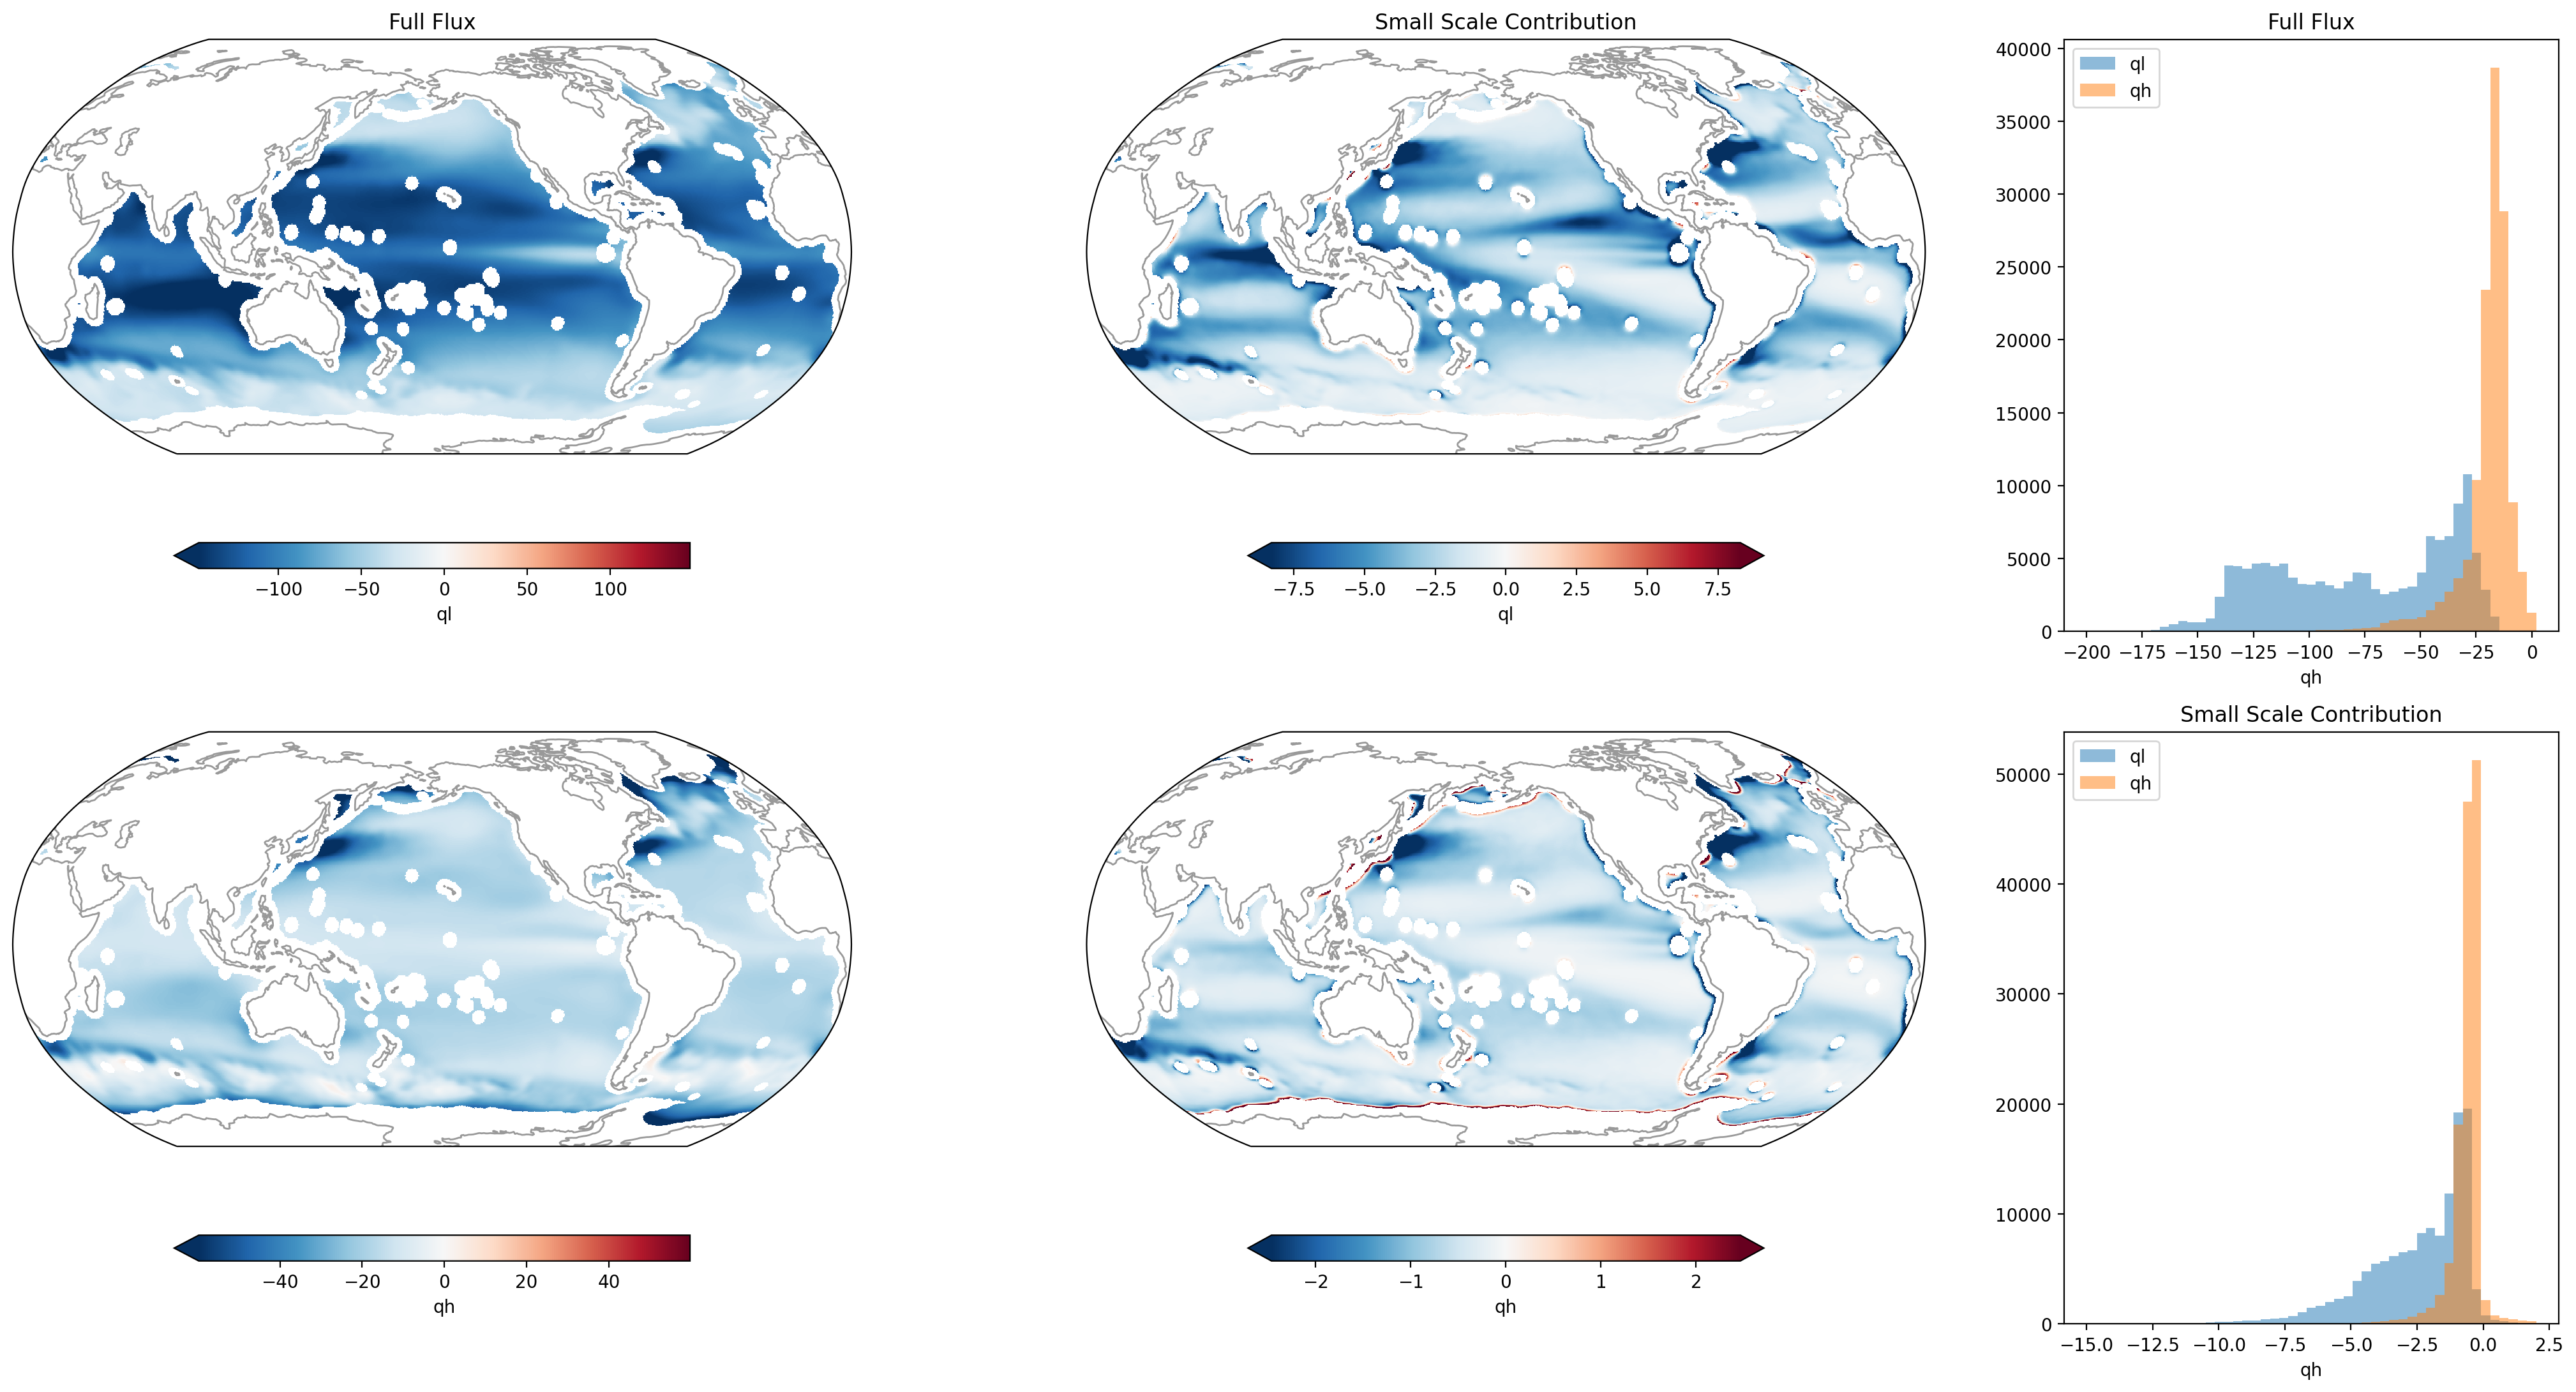

In [32]:
plot_kwargs = dict(transform=ccrs.PlateCarree(),cbar_kwargs = {'location':'bottom', 'shrink':0.5}, center=0)


fig = plt.figure(figsize = [7*3, 11])
gs = fig.add_gridspec(2, 5)


axarr = np.array(
    [
        [
            fig.add_subplot(gs[0, 0:2], projection=projection),
            fig.add_subplot(gs[0, 2:4], projection=projection),
            fig.add_subplot(gs[0, 4],),
        ],
        [
            fig.add_subplot(gs[1, 0:2], projection=projection),
            fig.add_subplot(gs[1, 2:4], projection=projection),   
            fig.add_subplot(gs[1, 4]),
        ]
    ])
        
for vi, var in enumerate(['ql', 'qh']):
    axarr_var = axarr[vi,:]
    
    da_plot_full = subsample(ds_full[var].mean('algo'), 5)
    da_plot_small= subsample(ds_small_scale[var].sel(smoothing='smooth_all').mean('algo'), 5)

    da_plot_full.plot(ax=axarr_var[0],robust=True, **plot_kwargs)
    
    da_plot_small.plot(ax=axarr_var[1], robust=True, **plot_kwargs)
    
    da_plot_full.plot.hist(bins=np.linspace(-200, 2, 50), ax=axarr[0,2], label=var, alpha=0.5)
    
    da_plot_small.plot.hist(bins=np.linspace(-15, 2, 50), ax=axarr[1,2], label=var, alpha=0.5)
    
# clean up titles
axarr[0,0].set_title('Full Flux')
axarr[0,1].set_title('Small Scale Contribution')
for ax in axarr[1,:-1].flat:
    ax.set_title('')
for ax in axarr[:,0:-1].flat:
    ax.coastlines(color='0.6')

axarr[0,2].set_title('Full Flux')
axarr[1,2].set_title('Small Scale Contribution')
axarr[0,2].legend()
axarr[1,2].legend()
fig.tight_layout()
#TODO: Make the maps a bit bigger (might have to split up the grid more finely for that

## Figure 2: Mechanisms

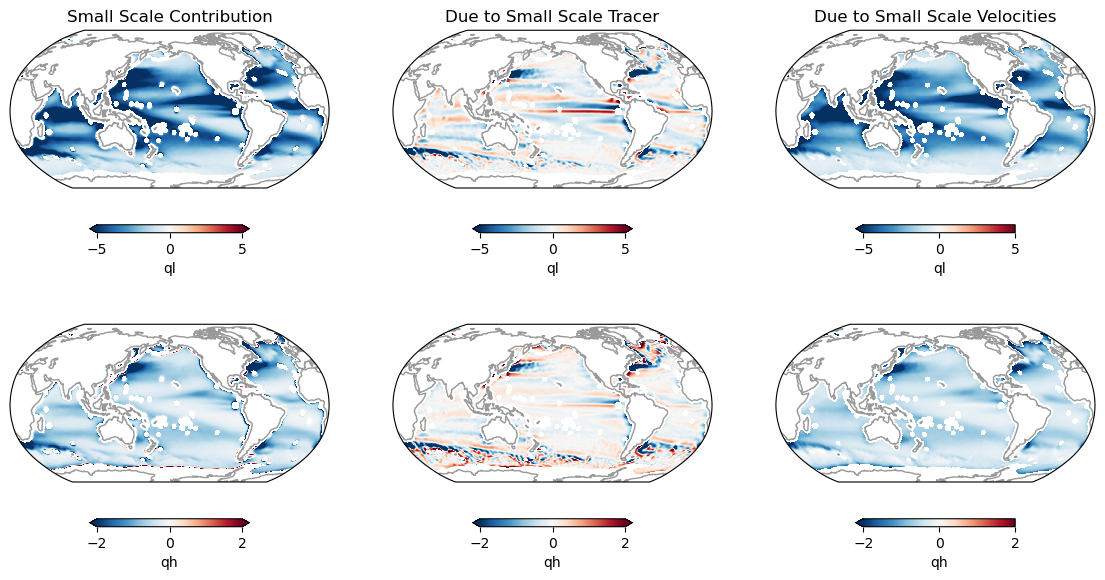

In [17]:
plot_kwargs = dict(transform=ccrs.PlateCarree(),cbar_kwargs = {'location':'bottom', 'shrink':0.5}, center=0)

ds_plot = subsample(ds_small_scale.mean('algo'), 5)

fig, axarr = plt.subplots(ncols=3, nrows=2, subplot_kw={'projection':projection}, figsize=[14, 7])
for vi, (var, vmax) in enumerate([('ql', 5), ('qh', 2)]):
    for si, smoothing in enumerate(['smooth_all', 'smooth_tracer', 'smooth_vel']):
        ax = axarr[vi,si]
        da_plot = ds_plot[var].sel(smoothing=smoothing).plot(ax=ax, vmax=vmax, **plot_kwargs)
    
# # clean up titles
axarr[0,0].set_title('Small Scale Contribution')
axarr[0,1].set_title('Due to Small Scale Tracer')
axarr[0,2].set_title('Due to Small Scale Velocities')
for ax in axarr[1,:].flat:
    ax.set_title('')
for ax in axarr.flat:
    ax.coastlines(color='0.6')

ql


<Figure size 640x480 with 0 Axes>

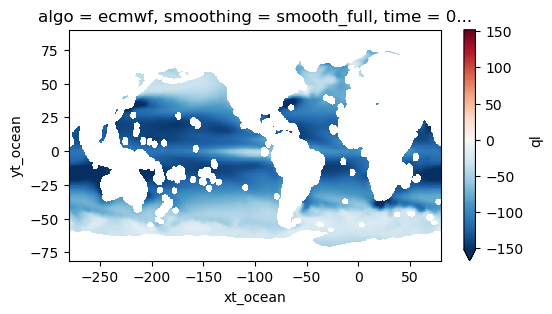

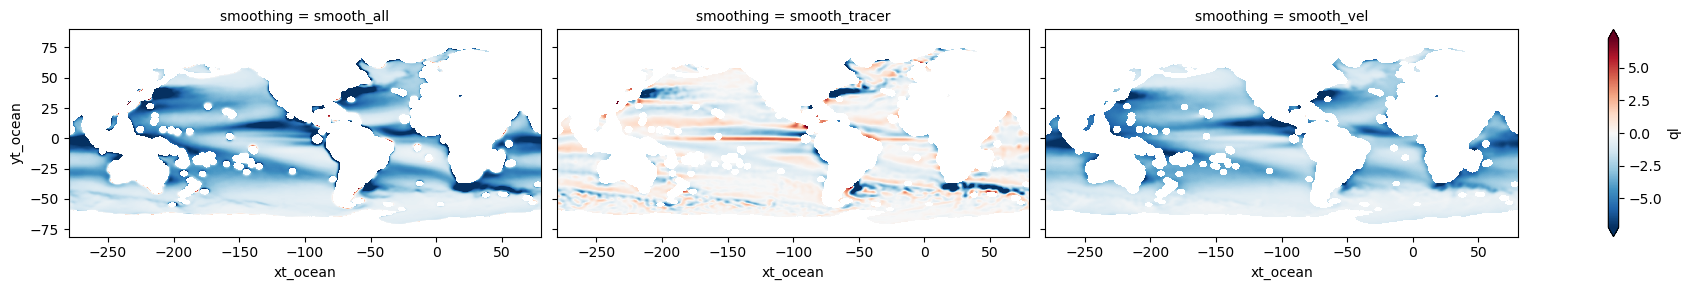

qh


<Figure size 640x480 with 0 Axes>

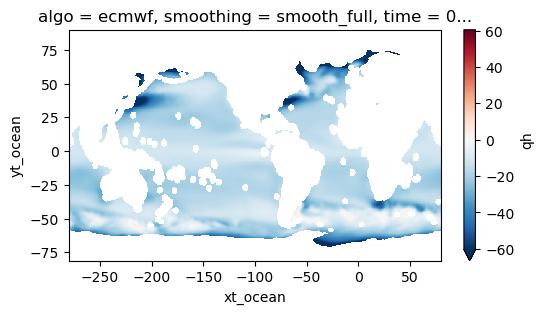

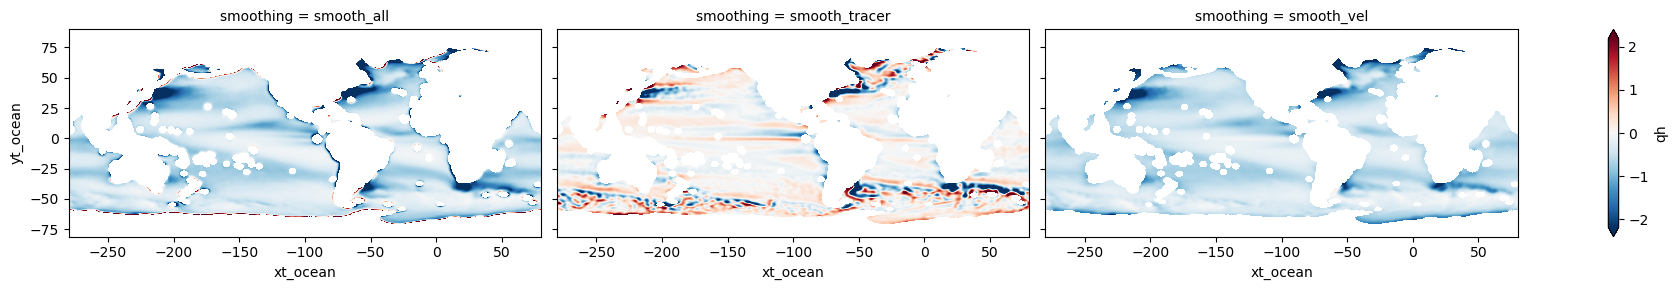

In [56]:
algo = 'ecmwf'
for var in ['ql', 'qh']:
    print(f"{var}")
    # the full field (smoothed)
    plt.figure()
    da_plot = ds_results_filtered[var].sel(smoothing='smooth_full').sel(algo=algo).load()
    da_plot = da_plot.where(~ice_mask, drop=True)
    da_plot = subsample(da_plot, 3)
    subsample(da_plot, 2).plot(robust=True, center=0, size=3, aspect=2)
    # plt.figure()
    da_plot = ds_small_scale[var].sel(algo=algo)
    da_plot = da_plot.where(~ice_mask, drop=True)
    da_plot = subsample(da_plot, 2)
    da_plot.plot(col='smoothing', robust=True, size=3, aspect=2)
    plt.show()

### Appendix: Difference of results across algos

/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


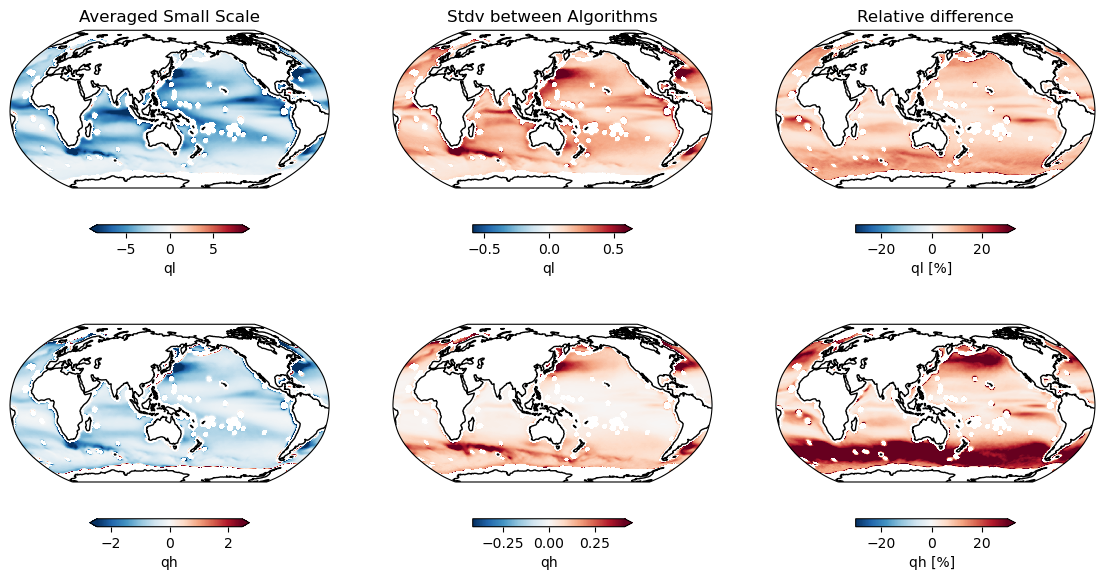

In [78]:
ds_plot = subsample(ds_small_scale.sel(smoothing='smooth_all'), 5)
plot_kwargs = dict(transform=ccrs.PlateCarree(),cbar_kwargs = {'location':'bottom', 'shrink':0.5}, center=0)

fig, axarr = plt.subplots(ncols=3, nrows=2, subplot_kw={'projection':projection}, figsize=[14, 7])
for vi, var in enumerate(['ql', 'qh']):
    da_plot = ds_plot[var]
    axarr_var = axarr[vi,:]
    mean = da_plot.mean('algo')
    std = da_plot.std('algo')
    relative = std/abs(mean)*100
    relative.attrs['name'] = 'Relative Error'
    relative.attrs['units'] = '%'
    
    # mean
    mean.plot(ax=axarr_var[0], robust=True, **plot_kwargs)
    # std
    std.plot(ax=axarr_var[1], robust=True, **plot_kwargs)
    # relative
    relative.plot(ax=axarr_var[2], vmax=30, **plot_kwargs)
    
# clean up titles
axarr[0,0].set_title('Averaged Small Scale')
axarr[0,1].set_title('Stdv between Algorithms')
axarr[0,2].set_title('Relative difference')
for ax in axarr[1,:].flat:
    ax.set_title('')
for ax in axarr.flat:
    ax.coastlines()

## Velocity Histograms (Appendix Plot)

In [10]:
from xhistogram.xarray import histogram 

In [11]:
import dask
from distributed import LocalCluster, Client

with dask.config.set({"distributed.scheduler.worker-saturation": "1.0"}):
    client = Client(LocalCluster())
client

2022-11-02 00:29:45,301 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-lc5wj4dm', purging
2022-11-02 00:29:45,302 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-m6vpnbb1', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/jbusecke/proxy/8787/status,
Dashboard: /user/jbusecke/proxy/8787/status,Workers: 4
Total threads: 16,Total memory: 58.87 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37729,Workers: 4
Dashboard: /user/jbusecke/proxy/8787/status,Total threads: 16
Started: Just now,Total memory: 58.87 GiB
Comm: tcp://127.0.0.1:41301,Total threads: 4
Dashboard: /user/jbusecke/proxy/42733/status,Memory: 14.72 GiB
Nanny: tcp://127.0.0.1:42185,


In [12]:
u_abs = (ds_original.u_relative**2 + ds_original.v_relative**2)**0.5
u_abs.name = 'velocity_magnitude'
u_abs = u_abs.isel(time=slice(0,700))

# get aroudnt this annoying bug (https://github.com/xgcm/xhistogram/issues/16)
# u_abs = u_abs.chunk({'time':3}) #Doesnt work
# the only way to do this, is to not compute the hist over time and then sum it...
hist = histogram(u_abs, bins=[np.arange(0, 30,0.1)], dim=['xt_ocean','yt_ocean'])
hist = hist.load()#.isel(time=73).plot.hist()

In [13]:
u_abs_smoothed = (ds_smoothed.u_relative_smoothed**2 + ds_smoothed.v_relative_smoothed**2)**0.5
u_abs_smoothed.name = 'velocity_magnitude'
u_abs_smoothed = u_abs_smoothed.isel(time=slice(0,700))


hist_smoothed = histogram(u_abs_smoothed, bins=[np.arange(0, 30,0.1)], dim=['xt_ocean','yt_ocean'])
hist_smoothed = hist_smoothed.load()#.isel(time=73).plot.hist()

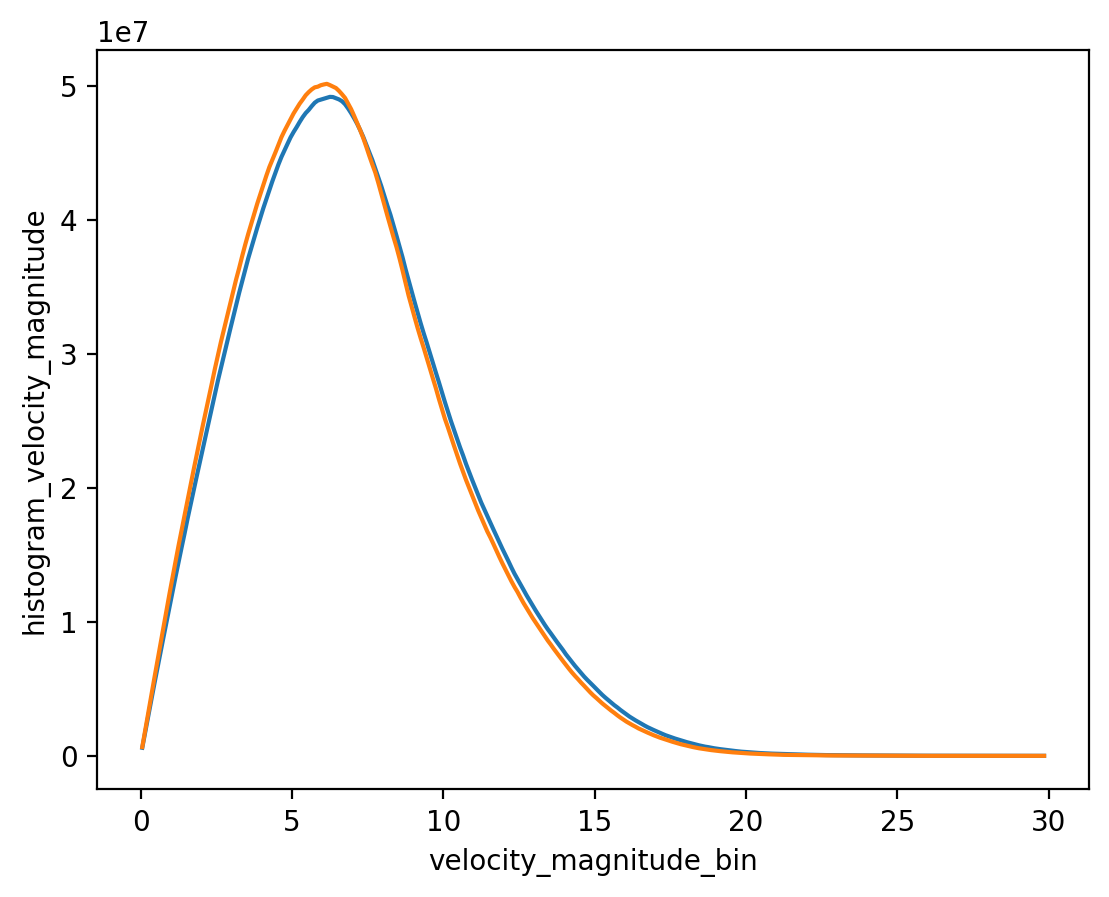

In [14]:
hist.sum('time').plot(label='unsmoothed')
hist_smoothed.sum('time').plot(label='smoothed')